# Test on simple synthetic data

This notebook generates some synthetic data based on a simple model and tests the inversion method on it.

The test will be used to show that the method works and is efficient. We'll also use it to compare the formulations using the Steepest Descent and Newton's method. The results show how each formulation performs on a regularized problem using smoothness constraints. This test uses cross-validation to determine the optimal regularization parameter. **We will assume that the reference level and density contrast are known**.

The data, model, and results generated here are saved to files in the respective folders for later use.

## Package imports

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division, print_function
import pstats
import datetime
import zipfile
import multiprocessing
import cPickle as pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn  # Makes the default style of the plots nicer

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.inversion import Smoothness2D
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3c4953c170e1e9d964325ccd133a5ef28e319e89


Load our custom classes and functions.

In [6]:
from mohoinv import TesseroidRelief, MohoGravityInvSpherical, make_mesh
from mohoinv import split_data, score_test_set, score_all, fit_all

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Create a model and generate synthetic data

Below we define a function that generates our tesseroid model of the Moho relief. The model assumes a homogeneous density contrast along the entire Moho. The relief of the Moho simulates the transition between continental and oceanic crust.

In [8]:
def generate_model():
    # Make a regular grid inside an area.
    # Grid points will be the center of the top of each tesseroid in the model
    shape = (40, 50)
    area = (10, 70, -50, 50)
    lat, lon = gridder.regular(area, shape)
    # Define our model Moho relief
    # The general flow from continent to ocean
    # is generated by the erf function
    relief = (
        -30e3 + 15e3*sp.special.erf((lon - 10)/20)
        - 10e3*utils.gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
        + 10e3*utils.gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
        - 10e3*utils.gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
        - 10e3*utils.gaussian2d(lat, lon, 10, 10, x0=30, y0=25)**2
        + 5e3*utils.gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15))
    density_contrast = 400
    density = density_contrast*np.ones_like(relief)
    # Define the reference level (height in meters). 
    # This is the Moho depth of the Normal Earth
    reference = -30e3
    # The density contrast is negative if the relief is below the reference
    density[relief < reference] *= -1
    # Make a TesseroidRelief using the make_mesh utility function and 
    # assign the density contrast values to it.
    model = make_mesh(area, shape, relief, reference)
    model.addprop('density', density)
    # Print some information
    print(u"Density contrast: {} kg/m³".format(density_contrast))
    print(u"Reference level: {} m".format(reference))
    print(u"Number of tesseroids: {} x {} = {}".format(shape[0], shape[1], 
                                                       model.size))
    return model

In [9]:
model = generate_model()

Density contrast: 400 kg/m³
Reference level: -30000.0 m
Number of tesseroids: 40 x 50 = 2000


Lets make a plot of our Moho model.

In [10]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='c')

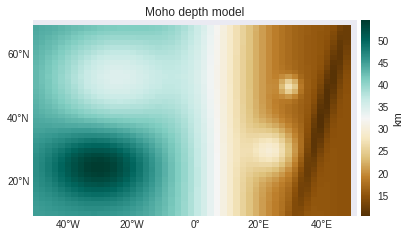

In [11]:
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))

plt.figure(figsize=(7, 3.5))
bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='BrBG')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.title("Moho depth model")

Generate the computation grid for our synthetic dataset. The grid will have half the spacing of the model. This way, we'll have more points than we'll need to run the inversion. The extra points will be separated into a *test dataset* for cross-validation (see section [Cross-validation](#Cross-validation) below).

In [12]:
# clon and clat are the coordinates of the center of each model cell
area = [model.clat.min(), model.clat.max(), model.clon.min(), model.clon.max()]
# Increase the shape to have half the grid spacing
full_shape = [s*2 - 1 for s in model.shape]
grid_height = 50e3
full_lat, full_lon, full_height = gridder.regular(area, full_shape, z=grid_height)
print('Number of grid points: {} x {} = {}'.format(full_shape[0], full_shape[1], 
                                                   full_shape[0]*full_shape[1]))
print('Grid height: {} m'.format(grid_height))

Number of grid points: 79 x 99 = 7821
Grid height: 50000.0 m


Forward model the synthetic data on a regular grid at a constant height and contaminate it with pseudo-random Gaussian noise.

In [13]:
%time full_data_noisefree = tesseroid.gz(full_lon, full_lat, full_height, model, njobs=ncpu)

CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 11 s


In [14]:
full_data = utils.contaminate(full_data_noisefree, 5, seed=0)

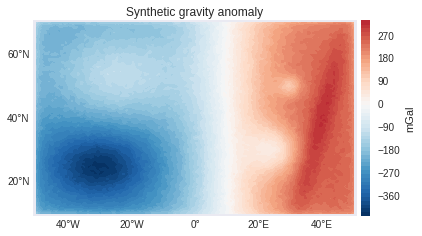

In [15]:
x, y = bm(full_lon, full_lat)

plt.figure(figsize=(7, 3.5))
ranges = np.abs([full_data.max(), full_data.min()]).max()
bm.contourf(x, y, full_data, 50, cmap='RdBu_r', tri=True, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01).set_label('mGal')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.title('Synthetic gravity anomaly')

## Save the model and synthetic data


We'll  save the data to a text file [../data/synthetic-data-simple.txt](../data/synthetic-data-simple.txt) for later use and plotting.

In [16]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Generated by sinthetic-simple.ipynb on {date}
# shape (nlat, nlon):
# {nlat} {nlon}
# lat lon height gravity_anomaly_noisefree gravity_anomaly_noisy
""".format(date=now, nlat=full_shape[0], nlon=full_shape[1])
with open('../data/synthetic-data-simple.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[full_lat, full_lon, full_height, full_data_noisefree, full_data],
               fmt='%.5f')

The model we'll save to a [Python pickle](https://docs.python.org/2/library/pickle.html) file. The `pickle` module allows us to serialize an object and load it back later. We'll use it to serialize the `model` object and save the file to the `model` folder.

In [17]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
model.metadata = "Generated by sinthetic-simple.ipynb on {date}".format(date=now)
with open('../model/synthetic-simple.pickle', 'w') as f:
    pickle.dump(model, f)

## Cross-validation

First, we must separate the dataset into two parts: one for the inversion, another for cross-validation. The inversion dataset will have double the grid spacing and (for this test) must fall on top of each grid cell. The remaining data will be used for cross-validation.

In [16]:
inversion_set, test_set, shape = split_data([full_lat, full_lon, full_height, full_data], full_shape, every_other=2)

print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], shape[0]*shape[1]))
print("Number of test set points: {}".format(test_set[0].size))

Number of inversion grid points: 40 x 50 = 2000
Number of test set points: 5821


Test if the inversion set falls on top of the model cells.

In [17]:
lat, lon, height, data = inversion_set
assert np.allclose(model.clon.ravel(), lon, rtol=1e-10, atol=0)
assert np.allclose(model.clat.ravel(), lat, rtol=1e-10, atol=0)

No errors means that both checks (`assert`) passed.

The score (MSE) should be zero (perfect fit) if we pass in the error-free model data.

In [18]:
score_test_set(model, full_lat, full_lon, full_height, full_data_noisefree, njobs=ncpu)

0.0

## Inversion setup

We need to make a mesh for the inversion. We'll use a mesh that is equal to the original model. This will make it easier to compare the inversion results with the true model.

In [19]:
mesh = model.copy(deep=True)

We also need to define an initial estimate because this is a non-linear inversion. Next, we create the data-misfit and regularization objects that we'll use in the inversions below.

In [20]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = np.ones(mesh.size)*(-60e3)

## Define plotting functions

These functions plot the results of the inversion for us. We'll define them all here and use them below for each inversion that we run.

In [23]:
def plot_fit(result, bm):
    solver = result['solution']
    predicted = solver[0].predicted()
    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Observed and predicted data ({})'.format(solver.stats_['method']))    
    levels = mpl.contourf(lon, lat, data, shape, 25, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_residuals(result):
    solver = result['solution']
    residuals = solver[0].residuals()
    
    plt.figure(figsize=(5, 4))
    plt.text(0.58, 0.8, 
             "mean = {:.2f}\n    std = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=15, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

def plot_estimate(result, bm):
    solver = result['solution']
    moho = solver.estimate_    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Estimated Moho depth ({})".format(solver.stats_['method']))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='BrBG')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_diff(result, model, bm):
    solver = result['solution']    
    moho = solver.estimate_    
    x, y = bm(moho.lons, moho.lats)
    
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Difference between true and estimated ({})'.format(solver.stats_['method']))  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_cv(result, log=True):
    regul_params = result['regul_params']
    scores = result['scores']
    best = result['best_index']
    solver = result['solution']
    plt.figure(figsize=(5, 3.5))
    plt.title('Cross-validation for {}'.format(solver.stats_['method']))
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout()
    
def plot_convergence(result):
    solver = result['solution']
    plt.figure(figsize=(5, 3.5))
    plt.title('Convergence of {}'.format(solver.stats_['method']))
    plt.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.ylabel('Goal function')
    plt.tight_layout()

## Solution using Steepest Descent

We'll keep the results in a Python dictionary (`dict`) along with all configuration and other metadata. We can then save this dict to a Pickle file and have inversion information saved with the results.

In [24]:
steepest = dict()  # For now, the results dict is empty

We'll make a Python dictionary (`dict`) to store the solver configuration for this method. `tol` is the tolerance level that controls the stopping criterion. `maxit` is the maximum allowed number of iterations. `linesearch=False` tells the algorithm not to perform a line search for the step size. 

In [25]:
steepest['config'] = dict(method='steepest', initial=initial, tol=0.1, maxit=10, linesearch=False)

Next, we define a list of the possible regularization parameters that will be considered during cross-validation. `logspace` generates a list of values evenly spaced in a logarithmic scale.

In [26]:
steepest['regul_params'] = np.logspace(-6, -1, 16)
steepest['regul_params']

array([  1.00000000e-06,   2.15443469e-06,   4.64158883e-06,
         1.00000000e-05,   2.15443469e-05,   4.64158883e-05,
         1.00000000e-04,   2.15443469e-04,   4.64158883e-04,
         1.00000000e-03,   2.15443469e-03,   4.64158883e-03,
         1.00000000e-02,   2.15443469e-02,   4.64158883e-02,
         1.00000000e-01])

Run the inversion for each value in `regul_params` (in parallel using all available cores). This takes some time to run. 

In [27]:
solvers = [(misfit + mu*regul).config(**steepest['config']) 
           for mu in steepest['regul_params']]

%time solutions = fit_all(solvers, njobs=ncpu)

CPU times: user 168 ms, sys: 72 ms, total: 240 ms
Wall time: 4min 53s


Store only the estimated Moho models. We can compute the predicted data from them later if we want.

In [28]:
steepest['solutions'] = [s.estimate_ for s in solutions]

Score the results against the test dataset.

In [29]:
%time steepest['scores'] = score_all(steepest['solutions'], test_set, points=False, njobs=ncpu)

CPU times: user 64 ms, sys: 32 ms, total: 96 ms
Wall time: 1min 32s


The best solution is the one with the smallest cross-validation score.

In [30]:
best = np.argmin(steepest['scores'])
steepest['best_index'] = best
steepest['solution'] = solutions[best]

### Save the results to a pickle file

Also save some metadata about it. Since the resulting pickle file will be large, we'll store it in a `zip` archive.

In [31]:
def pickle_results(results, fname):
    # Dump the results dict to a pickle file
    pickle_file = '{}.pickle'.format(fname)
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    results['metadata'] = "Generated by sinthetic-simple.ipynb on {date}".format(date=now)
    with open('results/{}'.format(pickle_file), 'w') as f:
        pickle.dump(results, f)
    # Zip the pickle file
    zipargs = dict(mode='w', compression=zipfile.ZIP_DEFLATED)
    with zipfile.ZipFile('results/{}.zip'.format(fname), **zipargs) as f:
        f.write('results/{}'.format(pickle_file), arcname=pickle_file)

In [32]:
pickle_results(steepest, 'synthetic-simple-steepest')

### Plot the results

Plot the cross-validation data. The graph will show the MSE per regularization parameter. The chosen solution is the one that minimizes the MSE.

(30, 65)

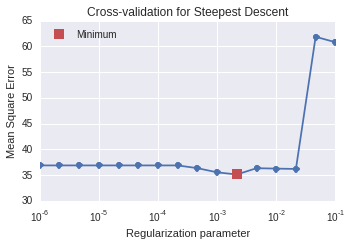

In [33]:
plot_cv(steepest, log=False)
plt.ylim(30, 65)

Plot the convergence of the best solution (goal function value per iteration) to see if the solution converges. Note that the y-axis is in a logarithmic scale.

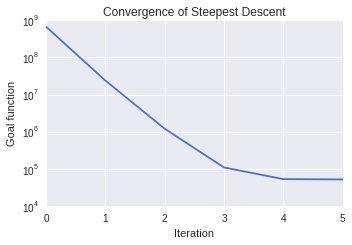

In [34]:
plot_convergence(steepest)

Now we can plot the results for the best solution found using Steepest Descent. The maps below show the data fit (observed vs predicted), a histogram of the inversion residuals, the estimated Moho depth, and the difference between the estimated and true Moho depths.

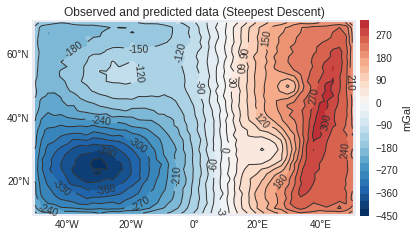

In [35]:
plot_fit(steepest, bm)

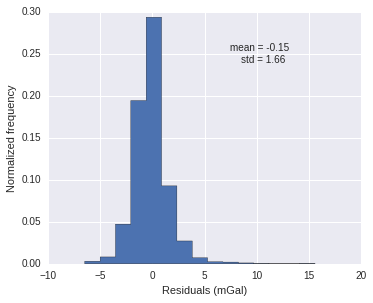

In [36]:
plot_residuals(steepest)

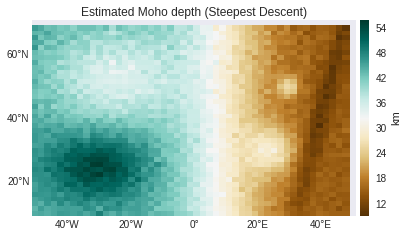

In [37]:
plot_estimate(steepest, bm)

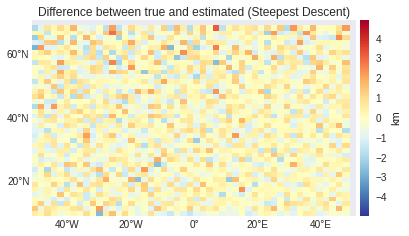

In [38]:
plot_diff(steepest, model, bm)

**Notice that the solution is still not smooth.** Even when using smoothness regularization, the solution using Steepest Descent does not provide a fully smooth Moho. The random errors in the data were still propagated to the solution.

The solution also seems to be over-fitting the data, even though we're using the optimal value determined by cross-validation. The predicted data fit even the high-frequency random noise in the data.

It seems that using only the gradient of the smoothness regularization with Steepest Descent is not enough to fully smooth the solution. However, this is the approach taken by [Santos et al. (2015)](http://dx.doi.org/10.1190%2Fgeo2014-0513.1) and they present smooth solutions. Maybe that is because they start out with a regularized solution as an initial estimate that is very close to the final solution already.

## Solution using Newton's method

Lets see if Newton's method yields a better solution. 

The configuration for the method is very similar to Steepest Descent but has no `linesearch` parameter.

In [21]:
newton = dict()

In [22]:
newton['config'] = dict(method='newton', initial=initial, tol=0.1, maxit=15)

In [23]:
newton['regul_params'] = np.logspace(-6, -1, 16)
newton['regul_params']

array([  1.00000000e-06,   2.15443469e-06,   4.64158883e-06,
         1.00000000e-05,   2.15443469e-05,   4.64158883e-05,
         1.00000000e-04,   2.15443469e-04,   4.64158883e-04,
         1.00000000e-03,   2.15443469e-03,   4.64158883e-03,
         1.00000000e-02,   2.15443469e-02,   4.64158883e-02,
         1.00000000e-01])

In [ ]:
solvers = [(misfit + mu*regul).config(**newton['config']) 
           for mu in newton['regul_params']]

%time solutions = fit_all(solvers, njobs=ncpu)

In [ ]:
newton['solutions'] = [s.estimate_ for s in solutions]

Score the results against the test dataset.

In [ ]:
%time newton['scores'] = score_all(newton['solutions'], test_set, points=False, njobs=ncpu)

In [ ]:
best = np.argmin(newton['scores'])
newton['best_index'] = best
newton['solution'] = solutions[best]

### Save the results to a pickle file

In [46]:
pickle_results(newton, 'synthetic-simple-newton')

### Plot the results

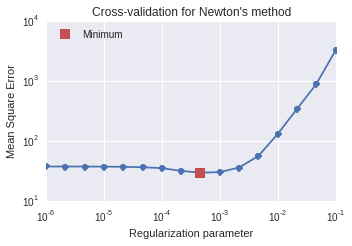

In [47]:
plot_cv(newton)

Notice that the cross-validation curve for Newton's method has a better defined minimum than for Steepest Descent.

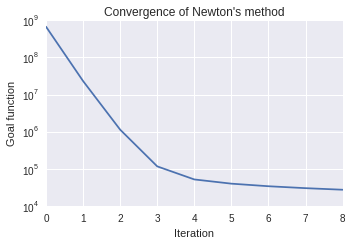

In [48]:
plot_convergence(newton)

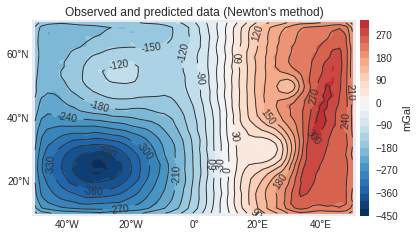

In [49]:
plot_fit(newton, bm)

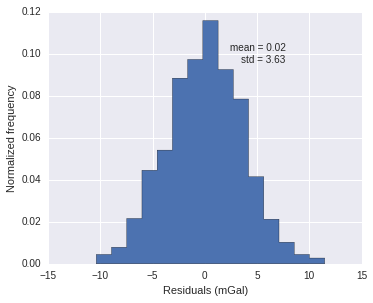

In [50]:
plot_residuals(newton)

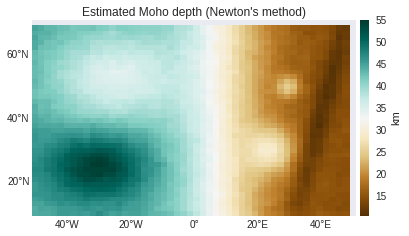

In [51]:
plot_estimate(newton, bm)

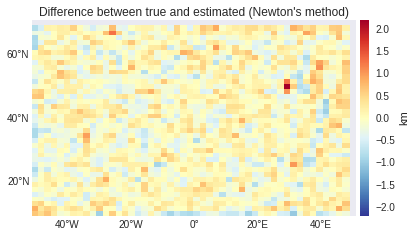

In [52]:
plot_diff(newton, model, bm)

The solution using Newton's method is smoother than the solution for Steepest Descent. We can also see that this solution does not over-fit the data. The predicted data (black contour lines) don't present the random noise seen in the observed data. The standard deviation of the residuals is also closer to the 5 mGal standard deviation used to generate the data errors.

## Profiling

We'll run the Python profiler (using the `%prun` IPython magic command) to measure how much time is speant on each function call during the inversion. This will allow us to see where time is being spent. I'll test the inversion by Gauss-Newton to see if solving the linear system has any impact on performance.

For consistency, we'll run the inversion using the optimal regularization parameter determined above by cross-validation.

In [ ]:
mu = newton['regul_params'][newton['best_index']]

The following cell runs the profiling on all the code inside it and saves the output to a pretty-printed file and to a raw data format.

In [ ]:
%%prun -q -T results/profiling.txt -D results/profiling-raw.dat
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
(misfit + mu*regul).config(**newton['config']).fit()

There are the first N lines of the pretty-printed profiling output. The list of functions is sorted by the time speant inside each specific function (`tottime`).

In [ ]:
!head -n 20 results/profiling.txt

We'll use the `pstats` module to investigate the raw profiling data for what we want. The three major time sinks in the inversion process that we'll investigate are: **solving sparse linear systems, matrix dot products, forward modeling**. We'll be looking at the cummulative time (`cumtime`) which is the total amount of time spent inside a given function.

After filtering the results to these three specific functions, we'll print the them to separate files for later use.

In [ ]:
def filter_profiling(keys, fname):
    output = 'results/{}'.format(fname)
    with open(output, 'w') as f:
        # Load the profiling data and set the output file
        st = pstats.Stats('results/profiling-raw.dat', stream=f)
        # Filter the data to isolate the time in the desired 
        # function and print to the file
        st.sort_stats('cumtime').print_stats(*keys)
    # Print the file contents
    !cat $output

First, investigate how time is spent solving sparse linear systems using conjugate gradient (the `cgs` function in `scipy.sparse.linalg.isolve.iterative`).

In [ ]:
filter_profiling(['scipy', 'cgs'], 'profiling-linsys.txt')

Now for the dot products of sparse matrices in `scipy.sparse`.

In [ ]:
filter_profiling(['scipy', 'sparse', 'dot'], 'profiling-dot.txt')

Finally, investigate the forward modeling using function `gz` of `fatiando.gravmag.tesseroid`.

In [ ]:
filter_profiling(['fatiando', 'tesseroid', 'gz'], 'profiling-forward.txt')

Extract the times from each file and store them in a dictionary.

In [ ]:
keys = 'forward dot linsys'.split()
times = {}
total_times = []
for k in keys:
    with open('results/profiling-{}.txt'.format(k)) as f:
        lines = f.readlines()
    times[k] = float(lines[-3].strip().split()[3])
    total_times.append(float(lines[2].strip().split()[-2]))
# Check if all total execution times read are equal
assert np.all(np.equal(total_times[0], total_times))
total_time = total_times[0]

In [ ]:
total_time, times

Calculate the percentage of the total time for each function.

In [ ]:
percentage = {k:100*times[k]/total_time for k in keys}

In [ ]:
for k in keys:
    print('{} = {:.5f} %'.format(k, percentage[k]))

Get the current processor name from the operating system.

In [ ]:
tmp = !cat /proc/cpuinfo | grep "model name"
processor = tmp[0].split(':')[1].strip()
print(processor)

Make the Latex table for the article.

In [ ]:
caption = """
        Total time spent on each function during a single inversion of
        simple synthetic data.
        The inversion was performed on a laptop computer with a
        {processor} processor.
        The total time for the inversion was {total_time:.3f} seconds.        
""".format(processor=processor, total_time=total_time)
print(caption)

In [ ]:
line = "{func} & {time:.3f} s & {percent:.3f}\%"
cg = line.format(func="Sparse conjugate gradient", 
                 time=times['linsys'], percent=percentage['linsys']) 
dot = line.format(func="Sparse dot product", 
                  time=times['dot'], percent=percentage['dot'])
fwd = line.format(func="Tesseroid forward modeling", 
                  time=times['forward'], percent=percentage['forward']) 

In [ ]:
table = r"""
\begin{table}
    \centering
    \caption{%s    }
    \label{profiling}
    \begin{tabular}{lcc}
        Function description & Time & Percentage of total time\\
        \hline 
        %s\\
        %s\\
        %s\\
        \hline
    \end{tabular}
\end{table}
""" % (caption, cg, dot, fwd)
print(table)

Print this table to a `.tex` file for inclusion in the manuscript.

In [ ]:
with open('../manuscript/profiling.tex', 'w') as f:
    f.write(table)

[]()